In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import clone_model

from dm_control import suite
from dm_control import viewer
import time

from matplotlib import pyplot as plt

In [2]:
def convert_observation(obs):
    list1 = [i.tolist() for i in list(obs.values())]
    list2 = np.array([])
    for sublist in list1:
        list2 = np.append(list2, sublist)
    return list2.reshape([1,25])

In [3]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-3, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [4]:
class Agent:
    def __init__(self, action_spec):
        self.memory = {
            "state":np.array([]), 
            "action":np.array([], dtype = int), 
            "reward":np.array([]),
            "new_state":np.array([]), 
            "done":np.array([])
        }
        self.random_proba = 1.0
        self.batch_size=64
        self.discount_rate=0.99
        self.tau=0.001
        self.action_dim = len(action_spec.minimum) #action_spec.shape
        self.action_spec = action_spec
        self.action_bound = 1
        self.input_size = 25
        self.noise = OrnsteinUhlenbeckActionNoise(mu = np.zeros(self.action_dim))

        # create critic model:
        input_obs = tf.keras.Input(shape=self.input_size, name = 'state')
        input_actions = tf.keras.Input(shape=(self.action_dim,), name = 'action')
        h = tf.keras.layers.Dense(400, activation = 'relu')(input_obs)
        tmp1 = tf.keras.layers.Dense(300, activation = 'relu')(h)
        action_abs = tf.keras.layers.Dense(300, activation = 'relu')(input_actions)
        h = tf.keras.layers.Add()([tmp1,action_abs])
        h = tf.keras.layers.Activation('relu')(h)
        pred = tf.keras.layers.Dense(1, kernel_initializer='random_uniform')(h)
        model = tf.keras.Model(inputs=[input_obs, input_actions], outputs=pred)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(loss='mse', optimizer=optimizer)
        self.critic_model = model
        """
        input_obs = tf.keras.Input(shape=self.input_size, name = 'state')
        input_actions = tf.keras.Input(shape=(self.action_dim,), name = 'action')
        h = tf.keras.layers.Dense(64, activation = 'relu')(input_obs)
        #h = BatchNormalization()(h)
        tmp1 = tf.keras.layers.Dense(64)(h)
        action_abs = tf.keras.layers.Dense(64, activation = 'relu')(input_actions)
        #action_abs = Activation('relu')(action_abs)
        #action_abs = BatchNormalization()(action_abs)
        h = tf.keras.layers.Add()([tmp1,action_abs])
        #h = Dense(64)(h)
        h = tf.keras.layers.Activation('relu')(h)
        #h = BatchNormalization()(h)
        pred = tf.keras.layers.Dense(1, kernel_initializer='random_uniform')(h)
        model = tf.keras.Model(inputs=[input_obs, input_actions], outputs=pred)
        model.compile(loss='mse', optimizer='Adam')
        self.critic_model = model
        """
        # create actor model:
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(300, input_dim = self.input_size, activation='relu'))
        model.add(tf.keras.layers.Dense(200, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_dim, activation = "relu"))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue = 1.0)
        model.compile(loss='mse', optimizer=optimizer)
        self.actor_model = model
        
        """
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(400, input_dim = self.input_size))#, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.Dense(300))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.Dense(self.action_dim, activation = "tanh"))
        model.compile(loss='mse', optimizer="Adam")
        self.actor_model = model
        """
        # target models:
        self.target_critic_model = clone_model(self.critic_model)
        self.target_actor_model = clone_model(self.actor_model)
 
    def sample_action(self, obs):
        action = self.actor_model.predict(obs)
        action = action + self.noise()# np.random.normal(0, 0.3, self.action_spec.shape)
        return action
    
    def store_info(self, obs, new_obs, action, reward, done):
        if len(self.memory["state"])>0:
            self.memory["state"] = np.vstack((self.memory["state"], obs))
            self.memory["new_state"] = np.vstack((self.memory["new_state"], new_obs))
            self.memory["action"] = np.vstack((self.memory["action"], action))
        else:
            if len(self.memory["state"])>1e6:
                for key in self.memory.keys():
                    self.memory[key] = self.memory[key][-0.5e6:]
            self.memory["state"] = np.array(obs)
            self.memory["new_state"] = np.array(new_obs)
            self.memory["action"] = np.array(action)
        self.memory["reward"] = np.append(self.memory["reward"], reward)
        self.memory["done"] = np.append(self.memory["done"], done)        
        
        
    def experience_replay(self):
        if len(self.memory["state"])>=self.batch_size:
            # get batch
            idxs = np.random.randint(len(self.memory["done"]), size=self.batch_size)
            batch = {
                "state": np.squeeze(self.memory["state"][idxs]), 
                "action": self.memory["action"][idxs], 
                "reward": self.memory["reward"][idxs], 
                "new_state": np.squeeze(self.memory["new_state"][idxs]), 
                "done": self.memory["done"][idxs]
            }
            
            # replay:
            target_q = self.target_critic_model.predict_on_batch([batch["new_state"], 
                                            self.target_actor_model.predict(batch["new_state"])])

            y = batch["reward"].reshape(self.batch_size,1) + np.multiply(target_q, 
                                                                         (self.discount_rate*(1-batch["done"])
                                                                         ).reshape(self.batch_size,1)
                                                                        )            
            # update critic
            self.critic_model.train_on_batch({"state": batch["state"], "action": batch["action"]}, y)    
            
           
            # update actor policy
            actions_pred = self.actor_model.predict(batch["state"])
            self.actor_model.fit(batch["state"], actions_pred, epochs = 1, verbose = 0)    
            
            # update networks           
            critic_weights =  self.critic_model.get_weights()
            actor_weights = self.actor_model.get_weights()
            
            old_critic_target_weights = self.target_critic_model.get_weights()
            old_actor_target_weights = self.target_actor_model.get_weights()
            
            for i in range(len(critic_weights)):
                old_critic_target_weights[i] = self.tau*old_critic_target_weights[i] + (1-self.tau)*critic_weights[i]
            self.critic_model.set_weights(old_critic_target_weights)
            
            for i in range(len(actor_weights)):
                old_actor_target_weights[i] = self.tau*old_actor_target_weights[i] + (1-self.tau)*actor_weights[i]
            self.actor_model.set_weights(old_actor_target_weights)


In [6]:
def save_models(agent):
    agent.critic_model.save('critic_model.h5')
    agent.actor_model.save('actor_model.h5')
    agent.target_critic_model.save('critic_model.h5')
    agent.target_actor_model.save('actor_model.h5')
    
def train_model(env, n_iterations, batch_size, discount_rate):
    scores = np.array([])
    last_rewards = np.array([])
    action_spec = env.action_spec()
    agent = Agent(action_spec)
    start = time.time()
    for iteration in range(n_iterations):
        if iteration % 50 == 0:
            save_models(agent)

        time_step = env.reset()  
        obs = convert_observation(time_step.observation)

        game_score = 0
        while not time_step.last():       
            # get action:
            action = agent.sample_action(obs)
            # make action:
            time_step = env.step(action[0])
            new_obs = convert_observation(time_step.observation)
            
            # update history:
            game_score += time_step.reward 
            done = int(time_step.reward >= 1.0)
            agent.store_info(obs, new_obs, action, time_step.reward, done)
            obs = new_obs
            # experience replay:
            agent.experience_replay()

        scores = np.append(scores, game_score)
        last_rewards = np.append(last_rewards, time_step.reward)
        if (iteration+1) % 50 == 0:
            print('Avg score for the last {} games: {}'.format(50, np.mean(scores[-50:])))
            print("{} minutes remaining".format((time.time()-start)/60))
    save_models(agent)
    return scores, last_rewards, agent


In [7]:
n_iterations = 1000
env = suite.load(domain_name="swimmer", task_name="swimmer6")
action_spec = env.action_spec()

scores, last_rewards, agent = train_model(env, n_iterations, batch_size=64, discount_rate=0.99)

Evaluate in 2 iterations


In [8]:
print(scores[-15:])
print(last_rewards[-15:])

[3.07817254 2.31684189]
[0.03112286 0.0229544 ]


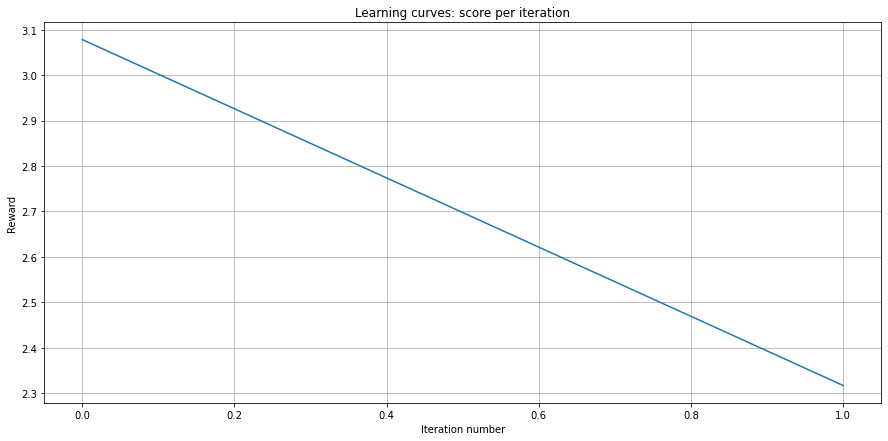

In [9]:
plt.figure(figsize=(15,7))
plt.grid()
x=list(range(len(scores)))
plt.plot(x, scores)

plt.title("Learning curves: score per iteration")
plt.ylabel("Reward")
plt.xlabel("Iteration number")
plt.savefig("learning_curves.png")
plt.show()

Average reward on test 100 games:  10.471917156275827


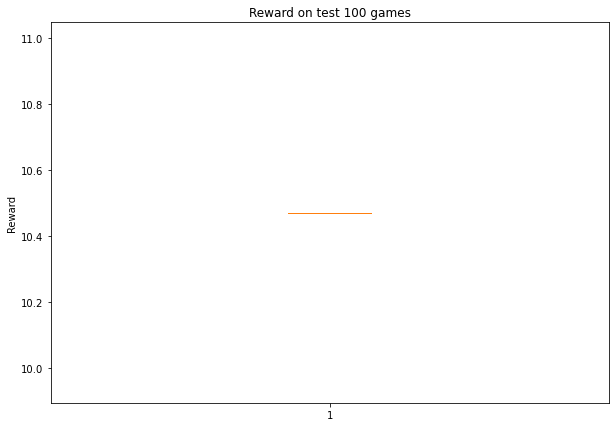

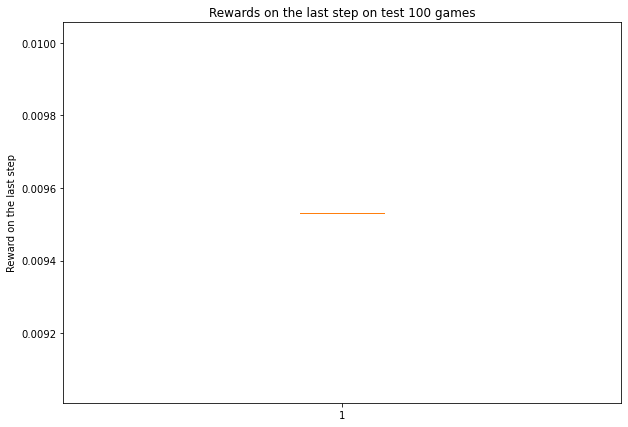

In [14]:
test_games = 100

test_scores = []
test_last_rewards = []
for game_index in range(test_games):
    score = 0
    time_step = env.reset()  
    obs = convert_observation(time_step.observation)
    while not time_step.last(): 
        action = agent.target_actor_model.predict(obs)
        time_step = env.step(action[0])
        obs = convert_observation(time_step.observation)
        score += time_step.reward

    test_scores.append(score)
    test_last_rewards.append(time_step.reward)

print("Average reward on test 100 games: ", np.mean(test_scores))

fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Reward on test 100 games')
ax.boxplot(test_scores,   
          showfliers=True)

ax.set_ylabel("Reward")
plt.savefig("rewards.png")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Rewards on the last step on test 100 games')
ax.boxplot(test_last_rewards,   
          showfliers=True)

ax.set_ylabel("Reward on the last step")
plt.savefig("last_rewards.png")
plt.show()